In [1]:
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.use("nbAgg") # Have to first change to a different backend in order to get the classes to reload on the next line.
# mpl.use("module://ipympl.backend_nbagg")
# mpl.use("module://" + __name__)
# mpl.use("module://matplotlib_inline.backend_inline")
# plt.ioff()

# mpl.get_backend()

In [3]:
# Target: Bar color demo
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_colors.html#sphx-glr-gallery-lines-bars-and-markers-bar-colors-py

# import matplotlib.pyplot as plt

# fig, ax = plt.subplots()

# fruits = ['apple', 'blueberry', 'cherry', 'orange']
# counts = [40, 100, 30, 55]
# bar_labels = ['red', 'blue', '_red', 'orange']
# bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']

# ax.bar(fruits, counts, label=bar_labels, color=bar_colors)

# ax.set_ylabel('fruit supply')
# ax.set_title('Fruit supply by kind and color')
# ax.legend(title='Fruit color')

# plt.show()

In [3]:
execfile("snp.py")

# start = time.monotonic_ns()
# tag_with_paths_deep(fig, "fig", mypy_result.graph)
# tag_with_paths_deep(ax, "ax", mypy_result.graph)
# print((time.monotonic_ns() - start) / 1e9)

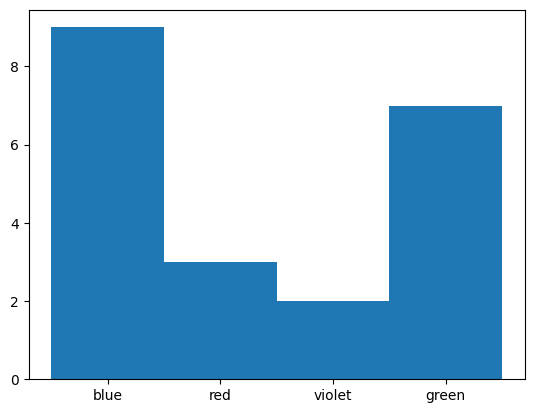

In [17]:
plt.ioff() # Someday I will figure out how to supress the extra plot
fig, ax = plt.subplots()

colors = ["blue", "red", "violet", "green"]
counts = [9, 3, 2, 7]

ax.bar(colors, counts, width=1.0, align="edge")


SNP(fig, locals(), cell_lineno, provenance_is_off_by_n_lines, notebook_code_through_cell, user_names=set(re.compile(r'\b').split(cell_code)))

In [27]:
print(mpl.axes._axes.Axes.set_title.__doc__)


        Set a title for the Axes.

        Set one of the three available Axes titles. The available titles
        are positioned above the Axes in the center, flush with the left
        edge, and flush with the right edge.

        Parameters
        ----------
        label : str
            Text to use for the title

        fontdict : dict
            A dictionary controlling the appearance of the title text,
            the default *fontdict* is::

               {'fontsize': rcParams['axes.titlesize'],
                'fontweight': rcParams['axes.titleweight'],
                'color': rcParams['axes.titlecolor'],
                'verticalalignment': 'baseline',
                'horizontalalignment': loc}

        loc : {'center', 'left', 'right'}, default: :rc:`axes.titlelocation`
            Which title to set.

        y : float, default: :rc:`axes.titley`
            Vertical Axes location for the title (1.0 is the top).  If
            None (the default) and :rc:`axes.tit

In [107]:
ast.parse("\"asdf\"").body[0].value

ast.parse


In [46]:
print(ast.unparse(ProvenanceTagger().visit(ast.parse(IPython.get_ipython().history_manager.input_hist_raw[-4]))))

provenance_is_off_by_n_lines = 4
cell_lineno = 47
cell_code = '# mpl.use("module://matplotlib_inline.backend_inline")\nplt.ioff()\nfig, ax = plt.subplots()\n\nfruits = [\'apple\', \'blueberry\', \'cherry\', \'orange\']\ncounts = [40, 100, 30, 55]\nsmiles = [1,23,10,100]\nax.bar(fruits, smiles)\nax.set_ylabel("fruit smile")\n\nSNP(fig, locals(), cell_lineno, provenance_is_off_by_n_lines, notebook_code_through_cell, user_names=set(re.compile(r\'\\b\').split(cell_code)))'
notebook_code_through_cell = 'import time\nimport numpy as np\nimport matplotlib as mpl\nimport matplotlib.pyplot as plt\n\n# mpl.use("nbAgg") # Have to first change to a different backend in order to get the classes to reload on the next line.\n# mpl.use("module://ipympl.backend_nbagg")\n# mpl.use("module://" + __name__)\n\nmpl.get_backend()\n# from typing import TypeVar\n\n# def testFn(a : TypeVar[T], b) -> T:\n#     return a\n# Target: Bar color demo\n# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_

In [6]:
# IPython.get_ipython().kernel.shell.ast_transformers = []
# ax.bar(fruits, counts)[0]
# object_type_node(fig, mypy_result.graph)
# ls = locals()
# obj = counts
# type_graph = mypy_result.graph
# thing_type_node = type_graph[obj.__class__.__module__].tree
# name_parts =obj.__class__.__qualname__.split(".")
# last_part = name_parts[-1]
# thing_type_node.names[last_part].type
# mypy_result.graph["current_notebook"].tree.names["counts"].type
import re; x = 10; print(x)

10


In [13]:
import mypy.subtypes

counts_type = mypy_result.graph["current_notebook"].tree.names["counts"].type

arraylike_type = mypy_result.graph["matplotlib.axes"].tree.names["Axes"].node.names["bar"].node.type.arg_types[1].items[1]

counts_type

# ( mypy.subtypes.is_subtype(counts_type, counts_type)
# , mypy.subtypes.is_subtype(counts_type, arraylike_type)
# , mypy.subtypes.is_subtype(arraylike_type, counts_type)
# )


builtins.list[builtins.int]

In [17]:
IPython.get_ipython().kernel.shell.ast_transformers = []

In [33]:
# ax.containers[0].get_children()
import ast

ast.parse("ax.bar(fruits, smiles)").body[0].value.func.value.id
call = ast.parse("ax.bar(fruits, smiles)").body[0].value

match call:
    case ast.Call(func = ast.Attribute(value)):
        print(func.__dir__())

['value', 'attr', 'ctx', 'lineno', 'col_offset', 'end_lineno', 'end_col_offset', '_fields', '__match_args__', '__module__', '__doc__', '__weakref__', '_attributes', '__new__', '__getattribute__', '__setattr__', '__delattr__', '__init__', '__reduce__', '__dict__', '__repr__', '__hash__', '__str__', '__lt__', '__le__', '__eq__', '__ne__', '__gt__', '__ge__', '__reduce_ex__', '__subclasshook__', '__init_subclass__', '__format__', '__sizeof__', '__dir__', '__class__']


In [ ]:
mypy_result.graph["current_notebook"].tree.names['ax'].type.type.names
mypy_result.graph["current_notebook"].tree.names['ax'].type.type.names['xaxis'].type.type.names
mypy_result.graph["current_notebook"].tree.names['ax'].type.type.names['xaxis'].type.type.direct_base_classes()[0].names
mypy_result.graph["current_notebook"].tree.names['ax'].type.type.names['xaxis'].type.type.direct_base_classes()[0].direct_base_classes()[0].names

mypy_result.graph["current_notebook"].tree.names['fig'].type.type.names['axes'].type

In [ ]:
ax.yaxis.__class__ # matplotlib.axis.YAxis
mypy_result.graph["matplotlib.axis"].tree.names["YAxis"].node.names
mypy_result.graph["matplotlib.axis"].tree.names["YAxis"].node.direct_base_classes()[0].names["set_label_text"].type

In [ ]:
class A:
    class B:
        pass

mypy_result.graph["current_notebook"].tree.names["A"].node.names["B"].node

In [ ]:
ax.yaxis.__class__.__module__
ax.yaxis.__class__.__qualname__
ax.yaxis.__class__.__module__.split(".") + ax.yaxis.__class__.__qualname__.split(".")

In [ ]:
this_cell_code = IPython.get_ipython().history_manager.input_hist_raw[-1]

this_cell_tokens = set(re.compile(r'\b').split(this_cell_code))

stuff = locals()

for token in list(stuff):
    if token in this_cell_tokens:
        print(token, stuff[token])


In [ ]:

def object_names(locals):
    out = {}
    for name, value in [(name, value) for name, value in locals.items() if name not in trivial_names and not callable(value)]:
        key = id(value)
        out[key] = out.get(key, set()).union({name})
    return out

object_names(locals())


In [ ]:
sources, options = mypy.main.process_options([file_path])

# # options.incremental = True
# options.incremental = False
# # options.show_traceback = True
# options.preserve_asts = True
# options.strict_optional = True
# options.warn_unused_configs = True
# # options.fine_grained_incremental = True
# # options.use_fine_grained_cache = True
# options.mypy_path = ["python-type-stubs-main"]
# options.follow_imports = "silent"
# options.follow_imports_for_stubs = True
# options.export_types = True

options.incremental = True
# options.incremental = False
# options.show_traceback = True
options.preserve_asts = True
options.strict_optional = True
options.warn_unused_configs = True
options.fine_grained_incremental = True
options.use_fine_grained_cache = True
options.local_partial_types = True # https://github.com/python/mypy/issues/4492
options.mypy_path = ["python-type-stubs-main"]
options.follow_imports = "silent"
options.follow_imports_for_stubs = True
options.export_types = True

# print(options)
fscache = mypy.fscache.FileSystemCache() # IDK if this is needed
mypy_result = mypy.build.build(sources, options=options, fscache=fscache)

fine_grained_build_manager = mypy.server.update.FineGrainedBuildManager(mypy_result)

fine_grained_build_manager.update([(module_name, file_path)], [])
fine_grained_build_manager.flush_cache()
fscache.flush()


In [ ]:
{"a": "b" for k,v in [(1,2)]}

In [ ]:
[arg.initializer for arg in mypy_result.graph["matplotlib.axis"].tree.names["YAxis"].node.direct_base_classes()[0].names["set_label_text"].type.definition.arguments]

mypy_result.graph["matplotlib.axis"].tree.names["YAxis"].node.direct_base_classes()[0].names["set_label_text"].node.type.arg_kinds
mypy_result.graph["matplotlib.axis"].tree.names["YAxis"].node.direct_base_classes()[0].names["set_label_text"].type.def_extras

In [ ]:
x = object()

In [6]:
# plt.ioff() # Someday I will figure out how to supress the extra plot
# fig, ax = plt.subplots()

# fruits = ['apple', 'blueberry', 'cherry', 'orange']
# counts = [40, 100, 30, 55]

# ax.bar(fruits, counts)
# ax.set_xlabel("Fruit Name")
# ax.set_ylabel("Number in Stock")
# ax.set_title("Fruits we haven't eaten")

# SNP(fig, locals(), cell_lineno, provenance_is_off_by_n_lines, notebook_code_through_cell, user_names=set(re.compile(r'\b').split(cell_code)))

AttributeError: 'NoneType' object has no attribute 'serialize'

In [11]:
print(ax.set_title.__doc__)


        Set a title for the Axes.

        Set one of the three available Axes titles. The available titles
        are positioned above the Axes in the center, flush with the left
        edge, and flush with the right edge.

        Parameters
        ----------
        label : str
            Text to use for the title

        fontdict : dict
            A dictionary controlling the appearance of the title text,
            the default *fontdict* is::

               {'fontsize': rcParams['axes.titlesize'],
                'fontweight': rcParams['axes.titleweight'],
                'color': rcParams['axes.titlecolor'],
                'verticalalignment': 'baseline',
                'horizontalalignment': loc}

        loc : {'center', 'left', 'right'}, default: :rc:`axes.titlelocation`
            Which title to set.

        y : float, default: :rc:`axes.titley`
            Vertical Axes location for the title (1.0 is the top).  If
            None (the default) and :rc:`axes.tit

In [ ]:
x = object()
y = object()
x == x

In [ ]:
def method_associations(artist):
    match artist:
        case mpl.axes.Axes() as ax:
            return [(ax.title, "set_title")]
        case mpl.axis.Axis() as axis:
            return [(axis.label, "set_label_text")]
        case _:
            return []



method_associations(ax.xaxis)